<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/cerchi_sensitivity_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install MONAI

In [ ]:
%%capture
!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"

# Import and set directory

In [ ]:
import os
import time
import torch
import tempfile
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image

import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.data import DataLoader, decollate_batch, create_test_image_2d

from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

2024-04-16 09:20:13.042405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 09:20:13.042535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 09:20:13.155068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
directory_path = '/kaggle/working/prova_cerchi_dir'
os.makedirs(directory_path, exist_ok = True)
os.environ["MONAI_DATA_DIRECTORY"] = directory_path
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# Auxiliary functions
First of all, it is necessary to execute all the cells belonging to this section.

In [ ]:
def create_image_2d (n_train, n_test, noise, r_min, r_max, seed):
  np.random.seed(seed)

  for i in range(n_train + n_test):
    image, label = create_test_image_2d(128, 128, num_seg_classes = 1, noise_max = noise, rad_min = r_min, rad_max = r_max)
    Image.fromarray((image * 255).astype("uint8")).save(os.path.join(root_dir, f"image{i:d}.png"))
    Image.fromarray((label * 255).astype("uint8")).save(os.path.join(root_dir, f"label{i:d}.png"))

  set_determinism(seed=0)

  images = sorted(glob(os.path.join(root_dir, "image*.png")))
  labels = sorted(glob(os.path.join(root_dir, "label*.png")))
  train_files = [{"image": image, "label": label} for image, label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image, label in zip(images[-n_test:], labels[-n_test:])]

  return train_files, val_files

In [ ]:
def transform(train_files, val_files):
  train_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ])

  val_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
  ])

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, val_loader, val_ds

In [ ]:
def model_and_train(train_loader, val_loader, max_epochs, val_ds, filters = 16):
  val_interval = 1
  VAL_AMP = True

  device = torch.device("cuda:0")
  model = SegResNet(
    spatial_dims = 2,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=filters,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)

  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-6)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=True, reduction="mean")
  dice_metric_train = DiceMetric(include_background=True, reduction="mean")

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  scaler = torch.cuda.amp.GradScaler()
  torch.backends.cudnn.benchmark = True

  epoch_loss_values = []
  metric_values = []
  metric_values_train = []
  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]
        labels  = [post_trans(i) for i in decollate_batch(labels)]
        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f} \nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device),val_data["label"].to(device))

                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_labels  = [post_trans(i) for i in decollate_batch(val_labels)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            print(f"Test dice: {metric:.4f}")

    print(f"Time: {(time.time() - epoch_start):.4f}")
  total_time = time.time() - total_start
  print(f"Train completed, total time: {total_time}.")
  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

  model.eval()
  with torch.no_grad():
    i = 0

    val_input = val_ds[i]["image"].unsqueeze(0).to(device)

    val_outputs = model(val_input)
    val_outputs = post_trans(val_outputs[0])

    plt.figure("fig")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.set_title("Image")
    ax1.imshow(val_ds[i]["image"][0, :, :].detach().cpu(), cmap="gray")

    ax2.set_title("Label")
    ax2.imshow(val_ds[i]["label"][0, :, :].detach().cpu())

    ax3.set_title("Output")
    ax3.imshow(val_outputs[0, :, :].detach().cpu())

    plt.show()

  return metric_values_train[-1], metric_values[-1], epoch_loss_values[-1]

In [ ]:
def plot_train_dim(n_train_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):
  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir, f"2D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max}).png")

  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(n_train_vec, metric_train, label = 'Train metric', marker='*')
  plt.plot(n_train_vec, metric_test, label = 'Test metric', marker='*')
  plt.xscale('log', base = 10)
  plt.xlabel("Train set dimension")
  plt.title(f"2D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(n_train_vec, loss, label = 'Train loss', marker='*', color='red')
  plt.xscale('log', base = 10)
  plt.xlabel("Train set dimension")
  plt.title(f"2D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.savefig(plot_path)

In [ ]:
def plot_noise(noise_vec, metric_train, metric_test, loss, r_min, r_max, max_epochs):

  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir, f"2D, epochs = {max_epochs}, r = ({r_min}, {r_max}).png")

  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(noise_vec, metric_train, label = 'Train metric', marker='*')
  plt.plot(noise_vec, metric_test, label = 'Test metric', marker='*')
  plt.xlabel("Noise")
  plt.title(f"2D, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(noise_vec, loss, label = 'Train loss', marker='*', color='red')
  plt.xlabel("Noise")
  plt.title(f"2D, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.savefig(plot_path)

In [ ]:
def plot_capacity(capacity_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):

  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir, f"2D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max}).png")

  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(capacity_vec, metric_train, label = 'Train metric', marker='*')
  plt.plot(capacity_vec, metric_test, label = 'Test metric', marker='*')
  plt.xscale('log', base = 10)
  plt.xlabel("Initial Filters")
  plt.title(f"2D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(capacity_vec, loss, label = 'Train loss', marker='*', color='red')
  plt.xscale('log', base = 10)
  plt.xlabel("Initial Filters")
  plt.title(f"2D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.savefig(plot_path)

In [ ]:
def delete_image(directory_path):
  file_list = os.listdir(directory_path)
  for file in file_list:
      file_path = os.path.join(directory_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)
      elif os.path.isdir(file_path):
          os.rmdir(file_path)
  print()

# Execute training
Here, the U-Net is trained in three different cases to analyze the network with respect to the training set size, noise level, and capacity.

Specify:
- minimum radius ("r_min": int)
- maximum radius ("r_max": int)
- noise to be added ("noise": float)
- training epochs ("max_epochs": int)

## Dimension train samples


Number of training images = 8
Number of testing images = 40

----------
epoch 1/40
Loss: 0.8636 
Train dice: 0.4496
Test dice: 0.7573
Time: 6.2697
----------
epoch 2/40
Loss: 0.6037 
Train dice: 0.7817
Test dice: 0.8197
Time: 3.1654
----------
epoch 3/40
Loss: 0.5217 
Train dice: 0.8388
Test dice: 0.8691
Time: 3.1711
----------
epoch 4/40
Loss: 0.4707 
Train dice: 0.8859
Test dice: 0.8825
Time: 2.7985
----------
epoch 5/40
Loss: 0.4318 
Train dice: 0.8934
Test dice: 0.8927
Time: 2.5869
----------
epoch 6/40
Loss: 0.4004 
Train dice: 0.9023
Test dice: 0.9005
Time: 2.8817
----------
epoch 7/40
Loss: 0.3800 
Train dice: 0.8953
Test dice: 0.8974
Time: 2.8051
----------
epoch 8/40
Loss: 0.3563 
Train dice: 0.8992
Test dice: 0.9056
Time: 3.0045
----------
epoch 9/40
Loss: 0.3329 
Train dice: 0.9085
Test dice: 0.9023
Time: 3.6459
----------
epoch 10/40
Loss: 0.3147 
Train dice: 0.9124
Test dice: 0.9099
Time: 2.8337
----------
epoch 11/40
Loss: 0.2949 
Train dice: 0.9177
Test dice: 0.9091
Tim

<Figure size 640x480 with 0 Axes>

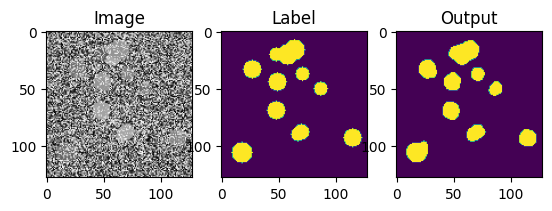



Number of training images = 16
Number of testing images = 40

----------
epoch 1/40
Loss: 0.7391 
Train dice: 0.5958
Test dice: 0.8122
Time: 3.6996
----------
epoch 2/40
Loss: 0.5128 
Train dice: 0.8470
Test dice: 0.8898
Time: 3.9985
----------
epoch 3/40
Loss: 0.4274 
Train dice: 0.8811
Test dice: 0.9065
Time: 4.0950
----------
epoch 4/40
Loss: 0.3672 
Train dice: 0.8954
Test dice: 0.9063
Time: 3.8262
----------
epoch 5/40
Loss: 0.3272 
Train dice: 0.8968
Test dice: 0.8842
Time: 3.7832
----------
epoch 6/40
Loss: 0.2997 
Train dice: 0.8924
Test dice: 0.9124
Time: 4.2413
----------
epoch 7/40
Loss: 0.2587 
Train dice: 0.9124
Test dice: 0.9200
Time: 3.7069
----------
epoch 8/40
Loss: 0.2365 
Train dice: 0.9155
Test dice: 0.9202
Time: 4.2194
----------
epoch 9/40
Loss: 0.2164 
Train dice: 0.9221
Test dice: 0.9256
Time: 3.6986
----------
epoch 10/40
Loss: 0.2045 
Train dice: 0.9216
Test dice: 0.9283
Time: 4.3295
----------
epoch 11/40
Loss: 0.1913 
Train dice: 0.9256
Test dice: 0.9208
T

<Figure size 640x480 with 0 Axes>

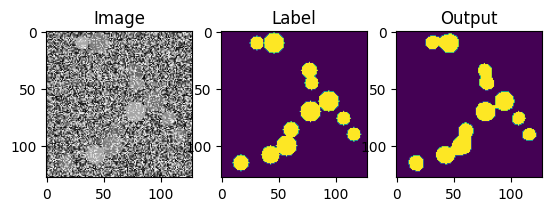



Number of training images = 32
Number of testing images = 40

----------
epoch 1/40
Loss: 0.6284 
Train dice: 0.7167
Test dice: 0.8857
Time: 5.4623
----------
epoch 2/40
Loss: 0.3946 
Train dice: 0.8915
Test dice: 0.9073
Time: 5.4702
----------
epoch 3/40
Loss: 0.3033 
Train dice: 0.9059
Test dice: 0.9210
Time: 5.4047
----------
epoch 4/40
Loss: 0.2420 
Train dice: 0.9184
Test dice: 0.9219
Time: 5.2611
----------
epoch 5/40
Loss: 0.2116 
Train dice: 0.9186
Test dice: 0.9128
Time: 5.2673
----------
epoch 6/40
Loss: 0.1879 
Train dice: 0.9218
Test dice: 0.9182
Time: 5.6149
----------
epoch 7/40
Loss: 0.1693 
Train dice: 0.9275
Test dice: 0.9251
Time: 5.7627
----------
epoch 8/40
Loss: 0.1581 
Train dice: 0.9300
Test dice: 0.9354
Time: 5.3856
----------
epoch 9/40
Loss: 0.1482 
Train dice: 0.9341
Test dice: 0.9329
Time: 5.5147
----------
epoch 10/40
Loss: 0.1463 
Train dice: 0.9314
Test dice: 0.9391
Time: 5.8472
----------
epoch 11/40
Loss: 0.1438 
Train dice: 0.9300
Test dice: 0.9313
T

<Figure size 640x480 with 0 Axes>

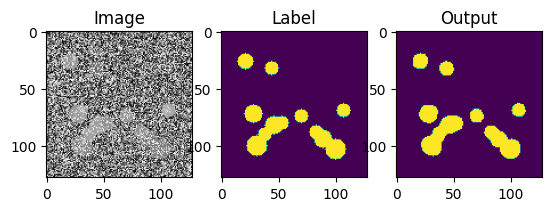



Number of training images = 64
Number of testing images = 40

----------
epoch 1/40
Loss: 0.5053 
Train dice: 0.8237
Test dice: 0.9096
Time: 8.8560
----------
epoch 2/40
Loss: 0.2736 
Train dice: 0.9131
Test dice: 0.9257
Time: 8.0833
----------
epoch 3/40
Loss: 0.1995 
Train dice: 0.9212
Test dice: 0.9214
Time: 8.3582
----------
epoch 4/40
Loss: 0.1668 
Train dice: 0.9261
Test dice: 0.9310
Time: 7.8265
----------
epoch 5/40
Loss: 0.1440 
Train dice: 0.9355
Test dice: 0.9394
Time: 8.6607
----------
epoch 6/40
Loss: 0.1357 
Train dice: 0.9362
Test dice: 0.9415
Time: 7.7458
----------
epoch 7/40
Loss: 0.1260 
Train dice: 0.9420
Test dice: 0.9456
Time: 8.5133
----------
epoch 8/40
Loss: 0.1191 
Train dice: 0.9460
Test dice: 0.9470
Time: 7.8454
----------
epoch 9/40
Loss: 0.1168 
Train dice: 0.9460
Test dice: 0.9535
Time: 8.4349
----------
epoch 10/40
Loss: 0.1121 
Train dice: 0.9498
Test dice: 0.9546
Time: 8.5635
----------
epoch 11/40
Loss: 0.1077 
Train dice: 0.9535
Test dice: 0.9569
T

<Figure size 640x480 with 0 Axes>

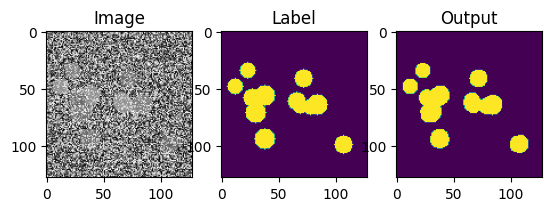



Number of training images = 128
Number of testing images = 40

----------
epoch 1/40
Loss: 0.3961 
Train dice: 0.8581
Test dice: 0.9277
Time: 14.2549
----------
epoch 2/40
Loss: 0.1826 
Train dice: 0.9239
Test dice: 0.9360
Time: 14.8233
----------
epoch 3/40
Loss: 0.1403 
Train dice: 0.9353
Test dice: 0.9287
Time: 14.0979
----------
epoch 4/40
Loss: 0.1230 
Train dice: 0.9436
Test dice: 0.9509
Time: 14.0778
----------
epoch 5/40
Loss: 0.1142 
Train dice: 0.9485
Test dice: 0.9562
Time: 14.3913
----------
epoch 6/40
Loss: 0.1094 
Train dice: 0.9507
Test dice: 0.9558
Time: 14.2720
----------
epoch 7/40
Loss: 0.1045 
Train dice: 0.9549
Test dice: 0.9605
Time: 14.4169
----------
epoch 8/40
Loss: 0.1015 
Train dice: 0.9575
Test dice: 0.9591
Time: 14.6689
----------
epoch 9/40
Loss: 0.0990 
Train dice: 0.9597
Test dice: 0.9642
Time: 14.0631
----------
epoch 10/40
Loss: 0.0973 
Train dice: 0.9612
Test dice: 0.9598
Time: 14.1429
----------
epoch 11/40
Loss: 0.0956 
Train dice: 0.9626
Test dic

<Figure size 640x480 with 0 Axes>

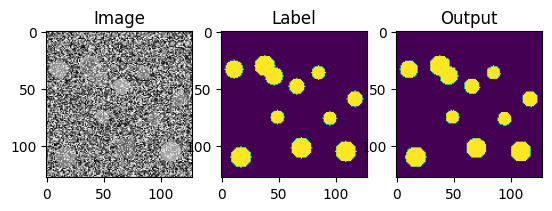



Number of training images = 256
Number of testing images = 40

----------
epoch 1/40
Loss: 0.2866 
Train dice: 0.8952
Test dice: 0.9357
Time: 26.4980
----------
epoch 2/40
Loss: 0.1325 
Train dice: 0.9382
Test dice: 0.9535
Time: 25.9832
----------
epoch 3/40
Loss: 0.1099 
Train dice: 0.9514
Test dice: 0.9589
Time: 26.2751
----------
epoch 4/40
Loss: 0.1011 
Train dice: 0.9580
Test dice: 0.9578
Time: 26.2501
----------
epoch 5/40
Loss: 0.0966 
Train dice: 0.9617
Test dice: 0.9658
Time: 26.8905
----------
epoch 6/40
Loss: 0.0937 
Train dice: 0.9643
Test dice: 0.9677
Time: 26.7853
----------
epoch 7/40
Loss: 0.0918 
Train dice: 0.9659
Test dice: 0.9662
Time: 26.5585
----------
epoch 8/40
Loss: 0.0896 
Train dice: 0.9680
Test dice: 0.9660
Time: 26.0972
----------
epoch 9/40
Loss: 0.0882 
Train dice: 0.9694
Test dice: 0.9699
Time: 26.4322
----------
epoch 10/40
Loss: 0.0869 
Train dice: 0.9708
Test dice: 0.9676
Time: 26.5672
----------
epoch 11/40
Loss: 0.0865 
Train dice: 0.9711
Test dic

<Figure size 640x480 with 0 Axes>

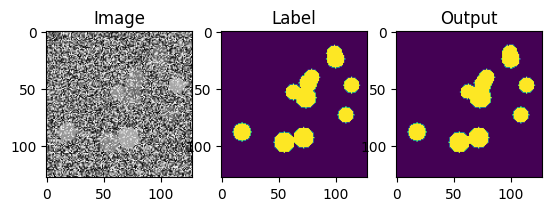

In [ ]:
n_train_vec  = [8, 16, 32, 64, 128, 256]
n_test = 40

noise = 1.5
r_min = 6
r_max = 10

max_epochs = 40

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for n_train in n_train_vec:
  print()
  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  train_files, val_files = create_image_2d(n_train, n_test, noise, r_min, r_max, n_train)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader,
                                                                       val_loader,
                                                                       max_epochs,
                                                                       val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

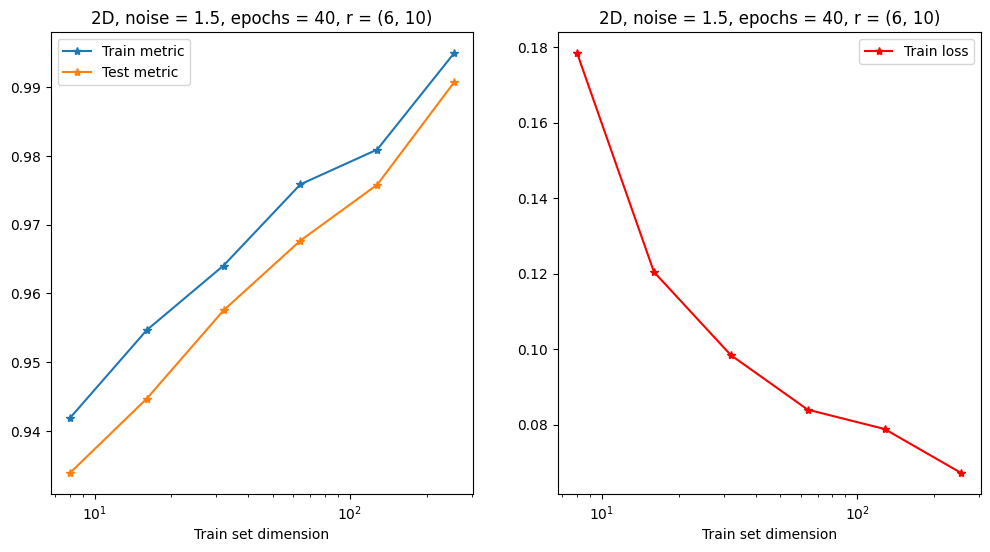

In [ ]:
plot_train_dim(n_train_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, noise, max_epochs)

## Noise

In [ ]:
n_train = 60
n_test = 40

noise_vec = [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]
r_min = 5
r_max = 10

max_epochs = 2

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for noise in noise_vec:
  print()
  print(f"Noise = {noise}")
  print()

  train_files, val_files = create_image_2d(n_train, n_test, noise, r_min, r_max, int(10*noise) )
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader,
                                                                       val_loader,
                                                                       max_epochs,
                                                                       val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

In [ ]:
plot_noise(noise_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, max_epochs)

## Capacity


Initial filters = 8

----------
epoch 1/40
Loss: 0.8442 
Train dice: 0.3180
Test dice: 0.4470
Time: 10.1506
----------
epoch 2/40
Loss: 0.7355 
Train dice: 0.5885
Test dice: 0.7485
Time: 9.6660
----------
epoch 3/40
Loss: 0.6176 
Train dice: 0.8066
Test dice: 0.8740
Time: 9.6205
----------
epoch 4/40
Loss: 0.4786 
Train dice: 0.8963
Test dice: 0.9104
Time: 9.9161
----------
epoch 5/40
Loss: 0.3513 
Train dice: 0.9232
Test dice: 0.9233
Time: 9.6655
----------
epoch 6/40
Loss: 0.2686 
Train dice: 0.9286
Test dice: 0.9365
Time: 10.0816
----------
epoch 7/40
Loss: 0.2158 
Train dice: 0.9367
Test dice: 0.9359
Time: 9.6978
----------
epoch 8/40
Loss: 0.1854 
Train dice: 0.9384
Test dice: 0.9449
Time: 9.9461
----------
epoch 9/40
Loss: 0.1635 
Train dice: 0.9438
Test dice: 0.9455
Time: 9.6650
----------
epoch 10/40
Loss: 0.1517 
Train dice: 0.9438
Test dice: 0.9494
Time: 10.5119
----------
epoch 11/40
Loss: 0.1419 
Train dice: 0.9465
Test dice: 0.9443
Time: 9.7202
----------
epoch 12/40
Loss

<Figure size 640x480 with 0 Axes>

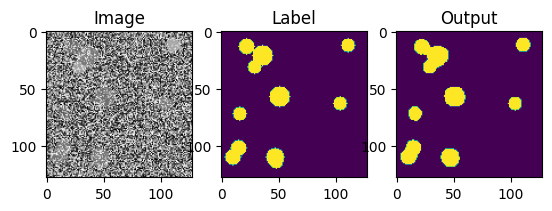



Initial filters = 16

----------
epoch 1/40
Loss: 0.5225 
Train dice: 0.8068
Test dice: 0.8915
Time: 9.8668
----------
epoch 2/40
Loss: 0.2862 
Train dice: 0.9108
Test dice: 0.9237
Time: 9.9910
----------
epoch 3/40
Loss: 0.2061 
Train dice: 0.9216
Test dice: 0.9272
Time: 10.4256
----------
epoch 4/40
Loss: 0.1714 
Train dice: 0.9256
Test dice: 0.9192
Time: 9.9966
----------
epoch 5/40
Loss: 0.1515 
Train dice: 0.9314
Test dice: 0.9370
Time: 10.0662
----------
epoch 6/40
Loss: 0.1363 
Train dice: 0.9380
Test dice: 0.9433
Time: 10.1927
----------
epoch 7/40
Loss: 0.1288 
Train dice: 0.9410
Test dice: 0.9323
Time: 9.8820
----------
epoch 8/40
Loss: 0.1236 
Train dice: 0.9432
Test dice: 0.9436
Time: 10.0303
----------
epoch 9/40
Loss: 0.1179 
Train dice: 0.9467
Test dice: 0.9465
Time: 9.8888
----------
epoch 10/40
Loss: 0.1132 
Train dice: 0.9500
Test dice: 0.9534
Time: 9.6112
----------
epoch 11/40
Loss: 0.1101 
Train dice: 0.9522
Test dice: 0.9528
Time: 9.6127
----------
epoch 12/40
L

<Figure size 640x480 with 0 Axes>

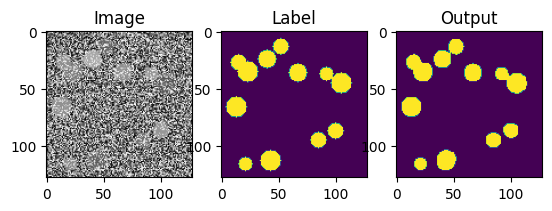



Initial filters = 32

----------
epoch 1/40
Loss: 0.4562 
Train dice: 0.8184
Test dice: 0.9022
Time: 10.5661
----------
epoch 2/40
Loss: 0.2109 
Train dice: 0.9153
Test dice: 0.9122
Time: 10.2460
----------
epoch 3/40
Loss: 0.1645 
Train dice: 0.9203
Test dice: 0.9321
Time: 10.1702
----------
epoch 4/40
Loss: 0.1394 
Train dice: 0.9320
Test dice: 0.9379
Time: 10.0210
----------
epoch 5/40
Loss: 0.1312 
Train dice: 0.9335
Test dice: 0.9410
Time: 10.4145
----------
epoch 6/40
Loss: 0.1210 
Train dice: 0.9408
Test dice: 0.9401
Time: 9.7891
----------
epoch 7/40
Loss: 0.1182 
Train dice: 0.9409
Test dice: 0.9468
Time: 9.9674
----------
epoch 8/40
Loss: 0.1131 
Train dice: 0.9452
Test dice: 0.9531
Time: 10.0140
----------
epoch 9/40
Loss: 0.1088 
Train dice: 0.9486
Test dice: 0.9458
Time: 9.7649
----------
epoch 10/40
Loss: 0.1075 
Train dice: 0.9500
Test dice: 0.9564
Time: 10.2247
----------
epoch 11/40
Loss: 0.1040 
Train dice: 0.9532
Test dice: 0.9516
Time: 9.7449
----------
epoch 12/4

In [ ]:
n_train = 60
n_test = 40

noise = 1.5
r_min = 6
r_max = 10

max_epochs = 40

capacity_vec = [2**i for i in range(3, 8)]

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for init_filters in capacity_vec:
  print()
  print(f"Initial filters = {init_filters}")
  print()

  train_files, val_files = create_image_2d(n_train, n_test, noise, r_min, r_max, init_filters)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader,
                                                                       val_loader,
                                                                       max_epochs,
                                                                       val_ds,
                                                                       init_filters)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

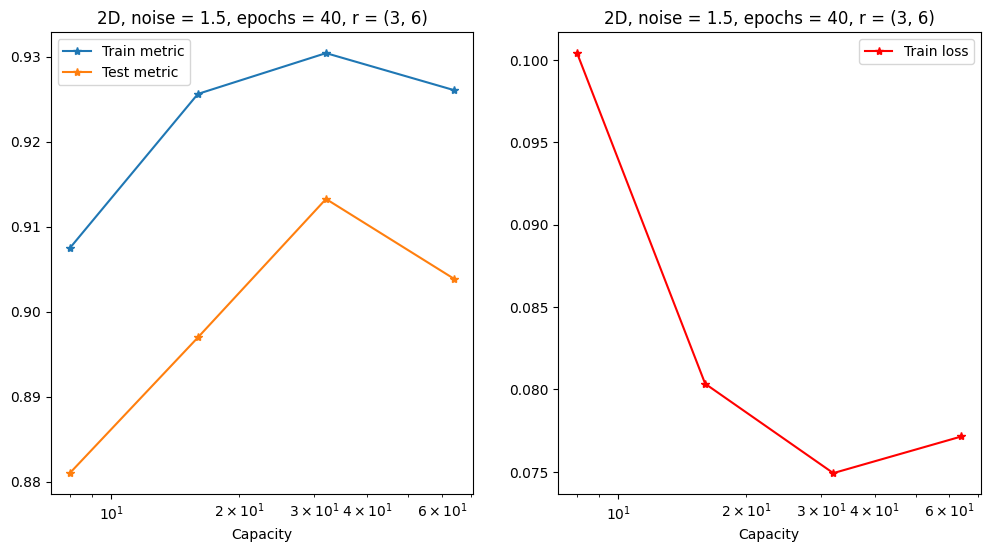

In [ ]:
plot_capacity(capacity_vec,
               metric_values_train_vec,
               metric_values_vec,
               epoch_loss_values_vec,
               r_min,
               r_max,
               noise,
               max_epochs)